# Infer ***cytosol*** -  3️⃣
(🚨🚨🚨🚨 Steps 4-9 depend on establishing a good solution here.)

--------------

## OBJECTIVE:  
### Infer sub-cellular component #3: ***cytosol***  in order to understand interactome 

To measure shape, position, and size of the cytosol of the cell body -- the cytosol minus the nucleus.    

Dependencies:
The ***cytoso*** inference rely on the ***nuclei*** AND ***cytosol*** inference.  Therefore all of the sub-cellular objects rely on this segmentation.



## preamble

1. imports
2. setup
3. get nuclei
4. get soma mask
5. get cytosol mask
6. export cytosol
7. get nuclues
8.  export nucleus



## IMPORTS

In [10]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np

from skimage.morphology import binary_erosion
# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)
from infer_subc_2d.utils.img import *
from infer_subc_2d.organelles import infer_soma_MCZ, fixed_infer_soma_MCZ, fixed_infer_nuclei

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## SETUP

In [11]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )                       

In [12]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [13]:

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET inferred NUCLEI



In [14]:

# nuclei_fname = "/Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"
nuclei = import_inferred_organelle("nuclei", meta_dict, out_data_path)

if nuclei is None:
    nuclei =  fixed_infer_nuclei(img_data) 
    out_file_n = export_inferred_organelle(nuclei, "nuclei", meta_dict, out_data_path)
    print(f"calculated nuclei. wrote {out_file_n}")
else:
    print(f"loaded nuclei from {out_data_path}")


loaded nuclei from /Users/ahenrie/Projects/Imaging/data/out


## GET SOMA MASK

Find the soma in our chozed Z-slice

In [15]:
# soma_fname = "/Users/ahenrie/Projects/Imaging/data/out/soma_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"
soma = import_inferred_organelle("soma", meta_dict, out_data_path)

if soma is None:
    soma = fixed_infer_soma_MCZ(img_data, nuclei)
    out_file_n = export_inferred_organelle(soma, "soma", meta_dict, out_data_path)
    print(f"calculated soma. wrote {out_file_n}")
else:
    print(f"loaded soma from {out_data_path}")


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


loaded soma from /Users/ahenrie/Projects/Imaging/data/out


## INFER NUCLEUS OBJECT

mask the nuclei with the soma to get a ***single*** nucleus.

In [16]:
nucleus_obj =  apply_mask(nuclei, soma) 


In [17]:

out_file_n = export_inferred_organelle(nucleus_obj, "nucleus", meta_dict, out_data_path)

/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


saved file: /Users/ahenrie/Projects/Imaging/data/out/nucleus_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff


##  infer ***cytosol***

## summary of steps

➡️ INPUT
- labeled ***nuclei*** (objective #1)
- labeled ***soma*** (objective #2)

PRE-PROCESSING
- erode ***nuclei*** (shrink)

CORE PROCESSING
  - XOR(***nuclei***, ***soma***)

- POST-PROCESSING
  - N/A

OUTPUT ➡️ 
- mask of ***cytosol***
- ***cytosol*** object (intensity)


## PRE-PROCESSING

In [18]:
###################
# PRE_PROCESSING
###################
nucleus_eroded = binary_erosion(nucleus_obj)  



## CORE PROCESSING

In [19]:
###################
# CORE_PROCESSING
###################

cyto_object = np.logical_and(soma,~nucleus_eroded)

cyto_object_xor = np.logical_xor(soma,nucleus_eroded)

#cyto_object = binary_dilation(cyto_object)

## Visualize with `napari` 

In [20]:


viewer = napari.view_image( #viewer.add_image(
    soma,
    scale=scale,
    opacity=0.3,
)    


In [21]:

viewer.add_image(
    nucleus_eroded,
    scale=scale,
    opacity=0.3,
)    


<Image layer 'nucleus_eroded' at 0x1680609d0>

In [22]:

viewer.add_image(
    nucleus_obj,
    scale=scale,
    opacity=0.3,
)    


<Image layer 'nucleus_obj' at 0x16805be50>

In [23]:

viewer.add_image(
    nuclei,
    scale=scale,
    opacity=0.3,
)    


<Image layer 'nuclei' at 0x16b341df0>

## DEFINE `_infer_cytosol` function

Based on the _prototyping_ above define the function to infer cytosol.  


In [24]:
# copy this to base.py for easy import

def _infer_cytosol(soma_mask, nuclei_object, erode_nuclei = False):
    """
    Procedure to infer cytosol from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal

    soma_mask: 
        a 3d image containing the soma signal

    erode_nuclei: 
        should we erode? Default False

    Returns
    -------------
    cytosol_mask 
        boolean np.ndarray
      
    """


    if erode_nuclei:
        # cytosol_mask = np.logical_and(soma_mask, ~binary_erosion(nuclei_object))
        cytosol_mask = np.logical_xor(soma_mask, binary_erosion(nuclei_object))
    else:
        # cytosol_mask = np.logical_and(soma_mask, ~nuclei_object)
        cytosol_mask = np.logical_xor(soma_mask, nuclei_object)


    return cytosol_mask


--------------------------

## TEST `infer_cytosol` exported functions


In [25]:
from infer_subc_2d.organelles.cytosol import infer_cytosol

_cytosol_mask =  _infer_cytosol(soma, nucleus_obj, erode_nuclei=False) 

cytosol_mask =  infer_cytosol(soma, nucleus_obj, erode_nuclei=False) 


In [26]:
out_file_n = export_inferred_organelle(cytosol_mask, "cytosol", meta_dict, out_data_path)

/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


saved file: /Users/ahenrie/Projects/Imaging/data/out/cytosol_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff


## Visualize  2


In [27]:


viewer.scale_bar.visible = True
viewer.add_image(
    cytosol_mask,
    scale=scale 
)

viewer.add_labels(
    _cytosol_mask,
    scale=scale 
)


<Labels layer '_cytosol_mask' at 0x16bc7adc0>

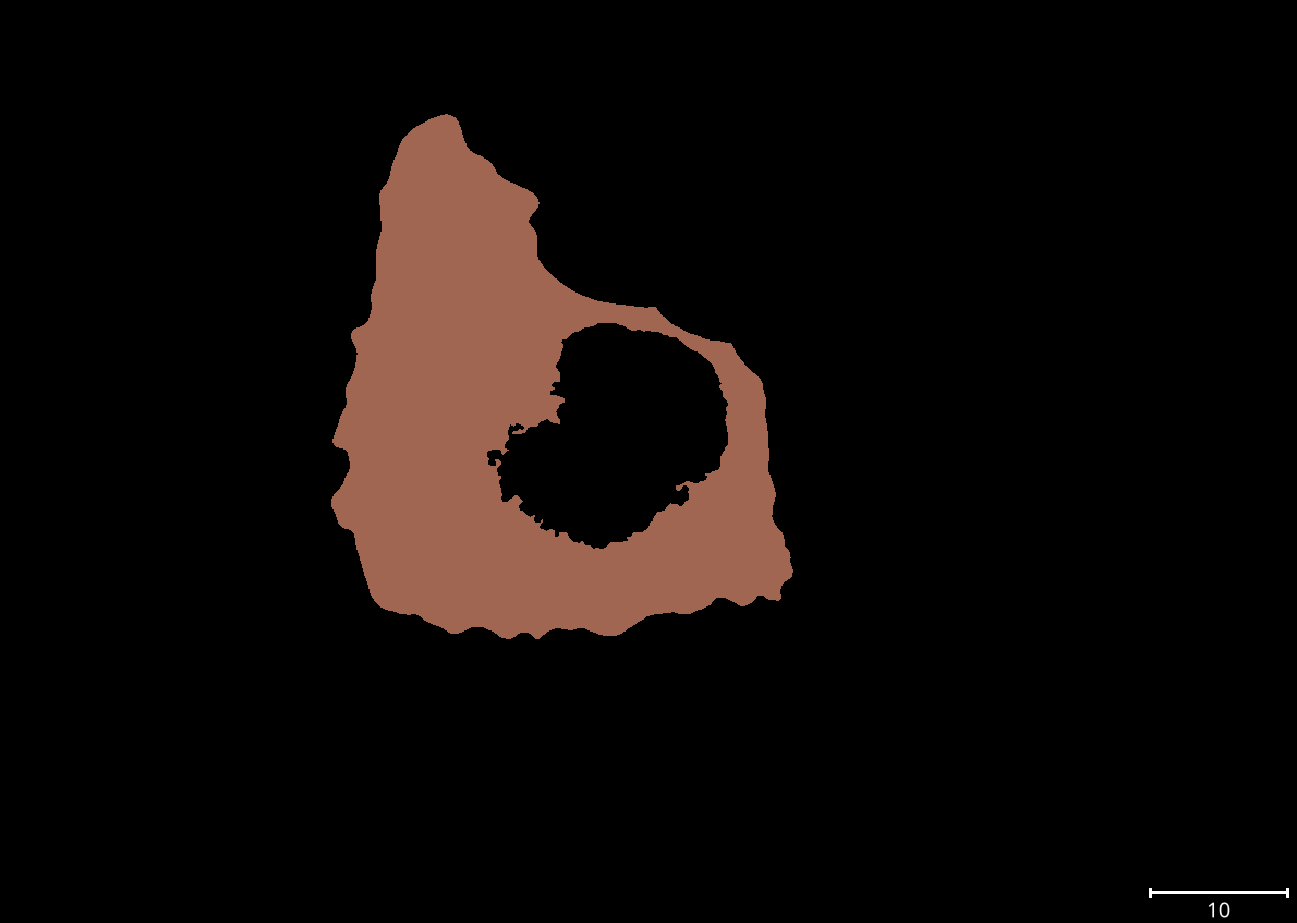

In [28]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)



In [29]:
viewer.close()

-----------------
Write the `infer_cytosol` spec to the widget json 

In [15]:
from infer_subc_2d.organelles_config.helper import add_function_spec_to_widget_json

_infer_cytosol=  {
        "name": "infer infer_cytosol",
        "python::module": "infer_subc_2d.organelles",
        "python::function": "infer_cytosol",
        "parameters": {
                "erode_nuclei" : {
                        "widget_type": "drop-down",
                        "data_type": "bool",
                        "options": [
                        True,
                        False
                        ]
            }
        }
}

add_function_spec_to_widget_json("infer_cytosol",_infer_cytosol, overwrite=True)

function infer_cytosol is already in all_functions.json
overwriting  infer_cytosol


1

--------------------------
## Write workflow .json
Now that we've added our function specs we can compose workflows.

In [16]:
def make_infer_cytosol_dict():
    """
    Procedure to infer infer from linearly unmixed input. (logical soma AND NOT nucleus)
    """
    step_name = []
    function_name = []
    category =[]
    parameter_values = []
    parent = []
   
    ###################
    # EXTRACT
    ###################   

    step_name.append("1")
    function_name.append("fixed_infer_nuclei")
    category.append("extraction")
    parameter_values.append( None )
    parent.append(0)

    step_name.append("2")
    function_name.append("fixed_infer_soma_MCZ")
    category.append("extraction")
    parameter_values.append( None )
    parent.append([0,1])

    step_name.append("3")
    function_name.append("apply_mask")
    category.append("postprocessing")
    parameter_values.append(None)
    parent.append([1,2])

    step_name.append("4")
    function_name.append("infer_cytosol")
    category.append("postprocessing")
    parameter_values.append(dict(erode_nuclei = False ))
    parent.append([2,3])

    out_dict = dict()
    for i,stepn in enumerate(step_name):
        entry = dict(category=category[i],
                            function=function_name[i],
                            parameter_values=parameter_values[i],
                            parent=parent[i]
        )
        if entry['parameter_values'] is None:
            _ = entry.pop('parameter_values')
        out_dict[stepn] = entry
        
    return out_dict

In [17]:
from infer_subc_2d.organelles_config.helper import write_workflow_json

infer_cytosol_dict = make_infer_cytosol_dict()

write_workflow_json("conf_1.3.cytosol_from_raw", infer_cytosol_dict)

PosixPath('/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles_config/conf_1.3.cytosol_from_raw.json')

-------------
## SUMMARY

The above details how the cytosol mask is inferred. 

### NEXT: INFER LYSOSOME

proceed to [04_infer_lysosome.ipynb](./04_infer_lysosome.ipynb)
